# Topic 1: Linear Regressors and Logistic Classifiers

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm

## Austin, TX Weather Dataset
### We will be using a publicly available dataset containing weather data to investigate linear regression and logistic regression classifiers.

In [32]:
# read data into a Pandas dataframe
df = pd.read_csv('../datasets/austin_weather.csv')
df.set_index('Date').sort_index()
# The "T" stands for "trace" amounts of precipitation, which we will set to 0
df['PrecipitationSumInches'] = df['PrecipitationSumInches'].replace('T', 0.0)
# Empty rows in the "Event" column will be replaced with "None"
df['Events'] = df['Events'].replace(' ', "None")

In [33]:
# Display the first 10 entries in the dataset
df.head(10)

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,None
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,None
3,2013-12-24,61,46,31,36,28,21,89,56,22,...,30.45,30.3,10,10,7,12,4,20,0,None
4,2013-12-25,58,50,41,44,40,36,86,71,56,...,30.33,30.27,10,10,7,10,2,16,0.0,None
5,2013-12-26,57,48,39,39,36,33,79,63,47,...,30.4,30.34,10,9,7,12,3,17,0,None
6,2013-12-27,60,53,45,41,39,37,83,65,47,...,30.39,30.34,10,9,7,7,1,11,0.0,None
7,2013-12-28,62,51,40,43,39,33,92,64,36,...,30.17,30.04,10,10,7,10,2,14,0.0,None
8,2013-12-29,64,50,36,49,41,28,92,76,60,...,30.1,29.99,10,10,4,17,5,24,0,None
9,2013-12-30,44,40,35,31,26,21,75,60,45,...,30.33,30.26,10,10,10,13,5,21,0,None


### Data clean-up and formatting

In [34]:
# define the columns that have numeric data that we want to analyze
data_columns = ['TempAvgF', 'DewPointAvgF', 'HumidityAvgPercent', 'SeaLevelPressureAvgInches', 'VisibilityAvgMiles', 'WindAvgMPH', 'PrecipitationSumInches']

In [35]:
# Convert data columns into numeric data
for dc in data_columns:
    df[dc] = pd.to_numeric(df[dc], errors='coerce')
# Remove rows in the dataset that have string entries in any of the data columns
# This can be done with less code, but using a loop makes it more clear what we are doing
rows_to_drop = []
for i in range(len(df)):
    for dc in data_columns:
        if np.isnan(df[dc][i]):
            rows_to_drop.append(i)
            break
df = df.drop(rows_to_drop)

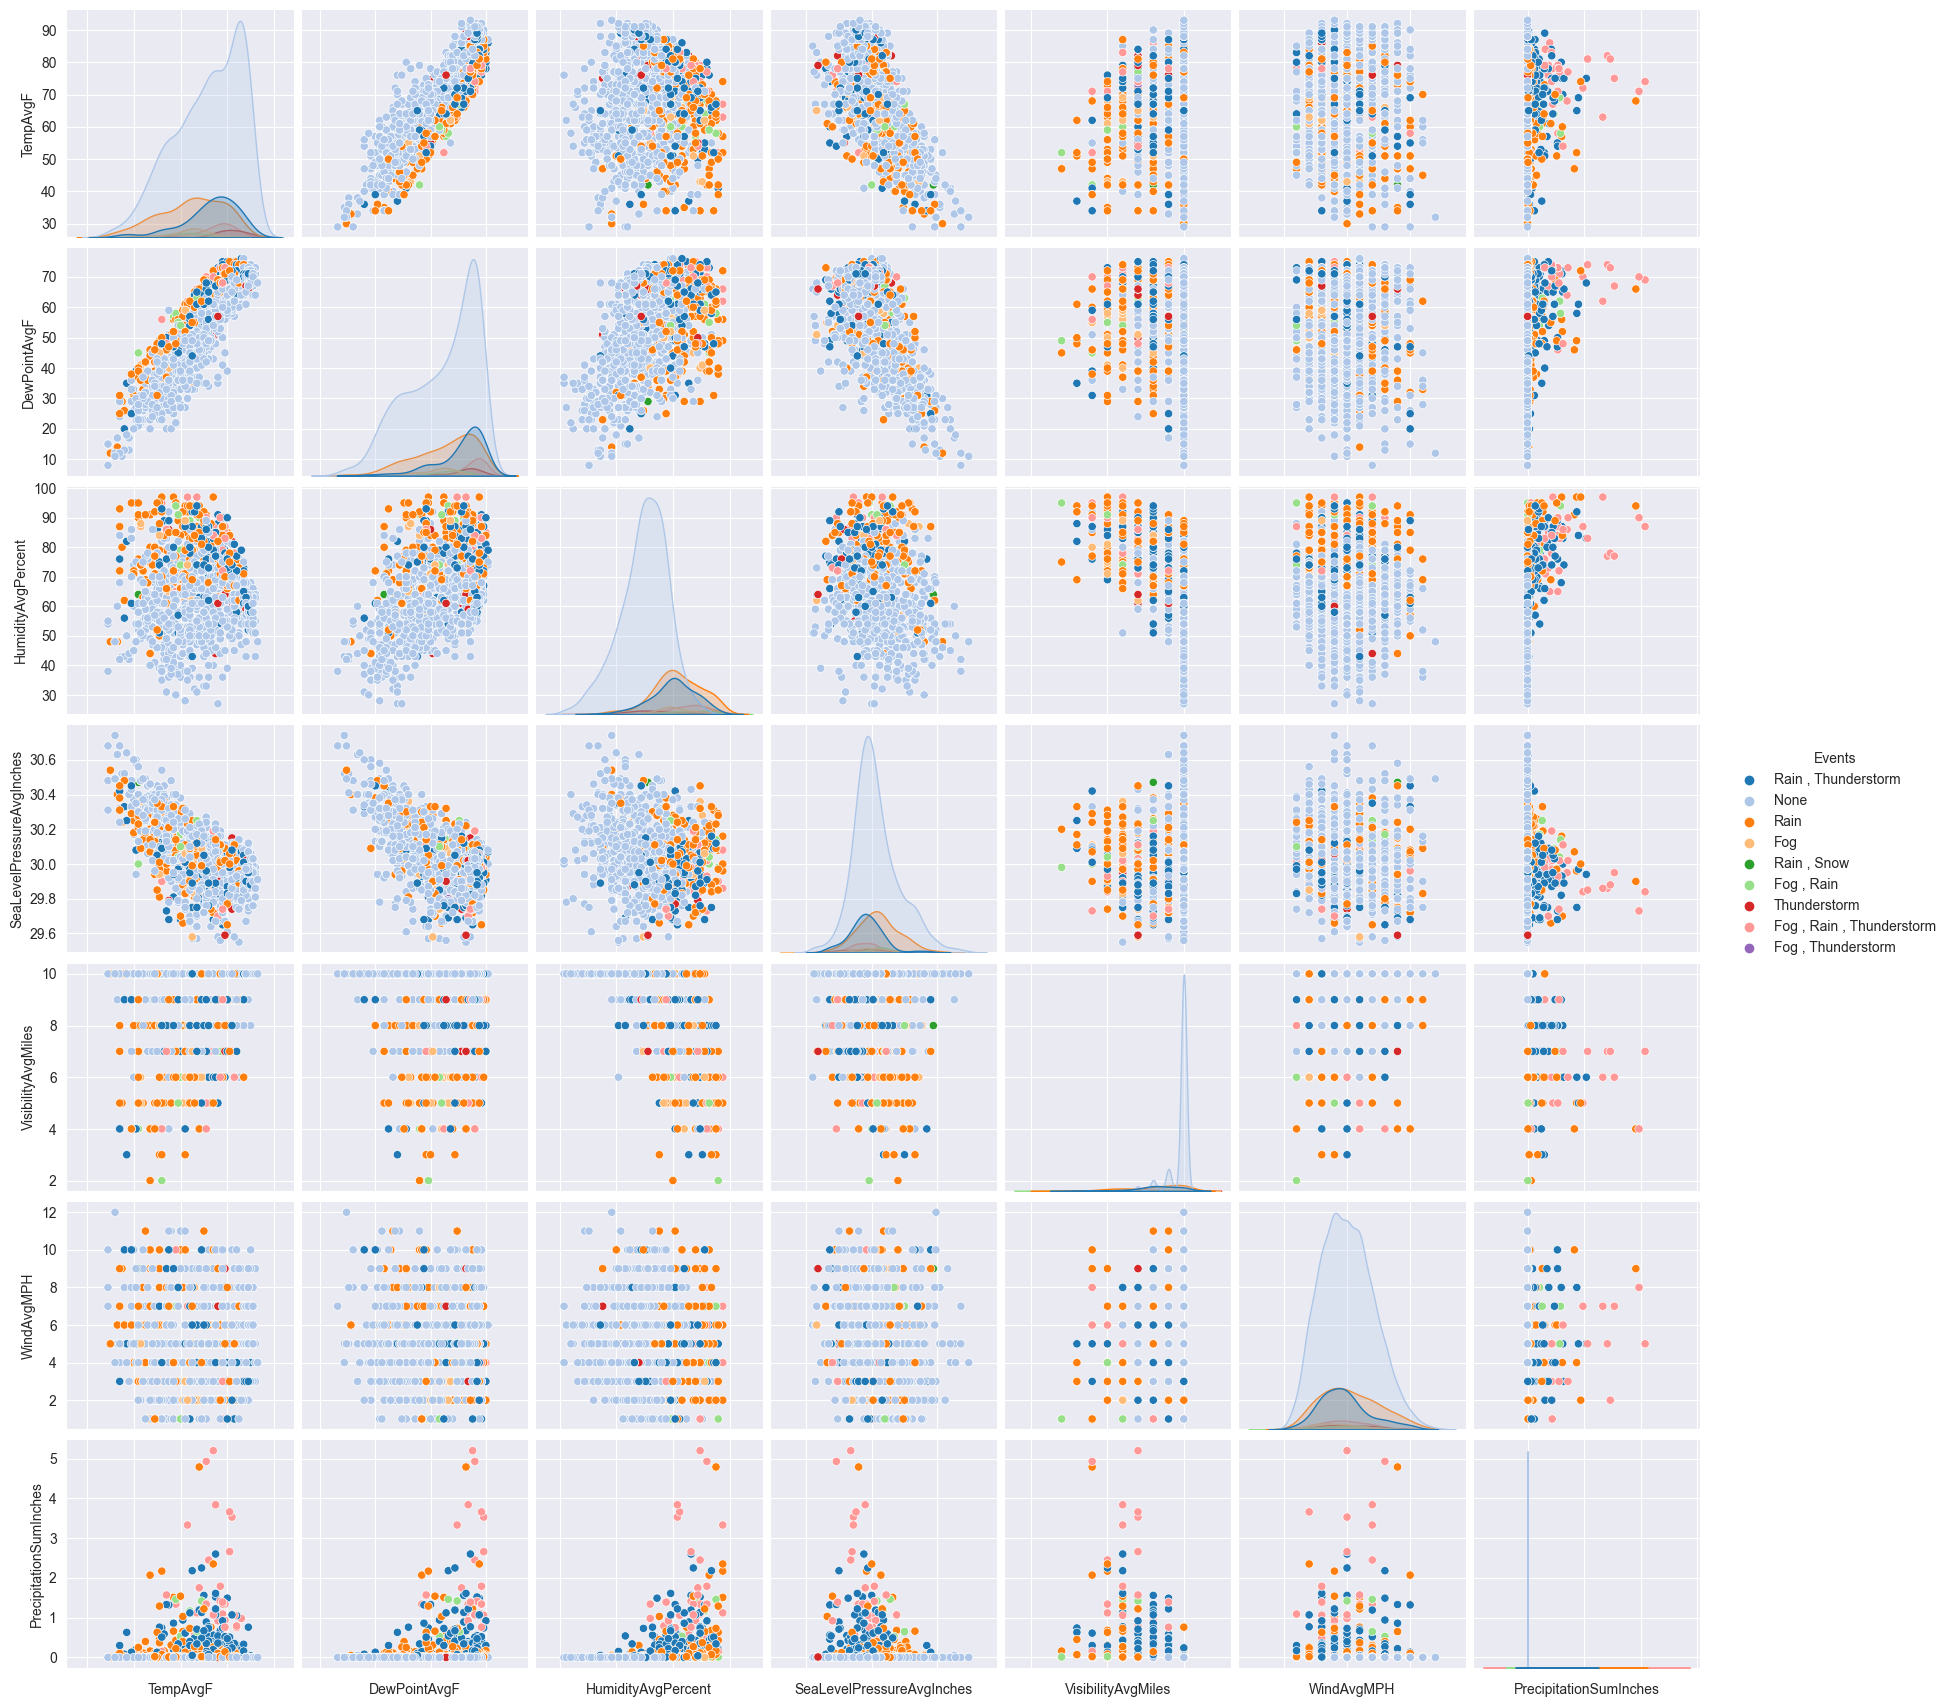

In [36]:
# Show pairwise relationships in data
plot = sns.pairplot(df, vars=data_columns, palette='tab20', hue='Events')
plot.set(xticklabels=[])
plt.show()

# Linear Regression
## In this example, we will train a linear model to predict the Dewpoint (F) based on temperature, humidity, sea level pressure, visibility, wind speed, and precipitation.

The following cell defines the linear regression function, the loss function, and the derivative of the loss function with respect to the weights and biases of the linear regression model. These are all needed to train the linear regressor through gradient descent.

In [37]:
# This is our linear regression function
def linear_regressor(weight_vector, bias_scalar, value_vector):
    return np.sum(weight_vector * value_vector, axis=1) + bias_scalar  # np.dot(weight_vector, value_vector) + bias_scalar


# We will be using the mean squared error as the loss function
def mse(y_predicted, y_actual):
    assert len(y_actual) == len(y_predicted)
    m = len(y_actual)
    mse_sum = 0.0
    for i in range(m):
        mse_sum += (y_predicted[i] - y_actual[i]) ** 2.0
    return 1 / m * mse_sum


# We need the derivative of the loss with respect to the weights and the bias
def dl_dw_db(x, y_predicted, y_actual):
    assert len(y_actual) == len(y_predicted)
    m = len(y_actual)
    dl_dw = 0.0
    dl_db = 0.0
    for i in range(m):
        error = (y_predicted[i] - y_actual[i])
        dl_dw += x[i] * error  # derivative of MSE with respect to weights
        dl_db += error  # derivative of MSE with respect to bias
    return 2 / m * dl_dw, 2 / m * dl_db


The function in the following cell performs the gradient descent training on the regressor. The learning rate and number of epochs are user-defined variables.

In [38]:
# define the training function, which will return the trained weight vector and training history
def train(x_data, y_data, learning_rate: float=0.001, num_epochs: int=10000, bias: float = 0.0):
    weights = np.ones(shape=x_data.shape[1], dtype=float)
    training_loss = []
    # run for user-defined number of epochs
    for _ in tqdm(range(num_epochs)):
        # Perform prediction
        y_pred_i = linear_regressor(weights, bias, x_data)
        # Calculate the loss
        loss_i = mse(y_pred_i, y_data)
        # Calculate the gradients
        dl_dw, dl_db = dl_dw_db(x_data, y_pred_i, y_data)
        # Calculate the new weights and biases through gradient descent
        weights -= learning_rate * dl_dw
        bias -= learning_rate * dl_db
        # Store the training loss at this epoch so that we can plot it later
        training_loss.append(loss_i)
    return weights, bias, training_loss

### We will split our data into separate training (70%) and testing (30%) datasets, and we will also standardize our data.

In [39]:
# Separate out the variables and regression target
variables = ['TempAvgF', 'HumidityAvgPercent', 'SeaLevelPressureAvgInches', 'WindAvgMPH', 'PrecipitationSumInches', 'VisibilityAvgMiles']
target = ['DewPointAvgF']

x_variables = df[variables].to_numpy()
y_targets = df[target].to_numpy().flatten()

# Standardize data
def standardize(data):
    for i in range(data.shape[1]):
        data[:,i] = (data[:,i] - np.mean(data[:,i])) / np.std(data[:,i])
standardize(x_variables)

# Perform train/test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_variables, y_targets, test_size=0.30, random_state=42)

# Train the regressor
weights, bias, training_loss = train(x_train, y_train)

  0%|          | 0/10000 [00:00<?, ?it/s]

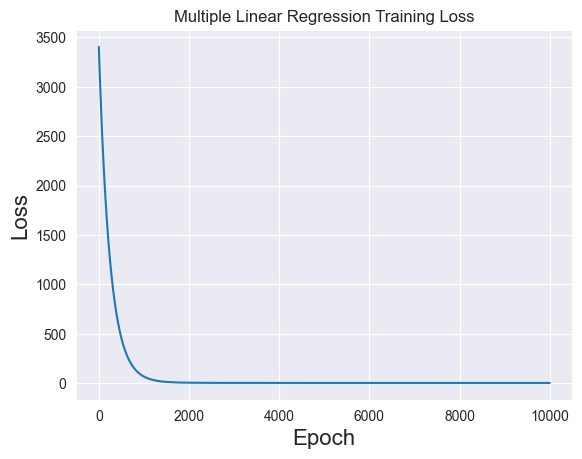

In [40]:
# Plot the training loss
plt.plot(training_loss)
plt.xlabel("Epoch", size=16)
plt.ylabel("Loss", size=16)
plt.title("Multiple Linear Regression Training Loss")
# plt.ylim((0, 200))
plt.show()

In [41]:
# Perform prediction on the testing data
test_predictions = linear_regressor(weights, bias, x_test)
results_df = pd.DataFrame({"predictions": test_predictions, "actual": y_test})

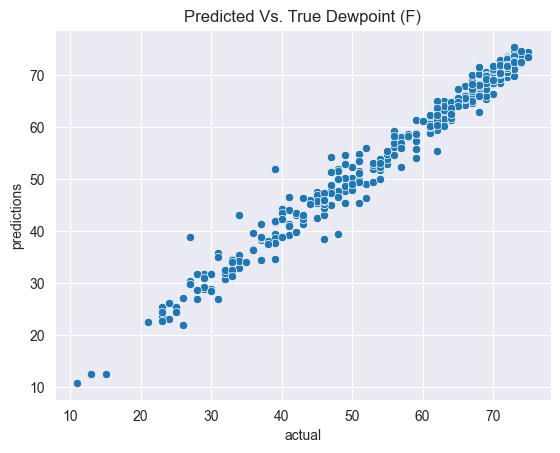

In [42]:
# Show the predicted vs actual Dewpoint (F)
sns.scatterplot(results_df, x='actual', y='predictions')
plt.title("Predicted Vs. True Dewpoint (F)")
plt.show()

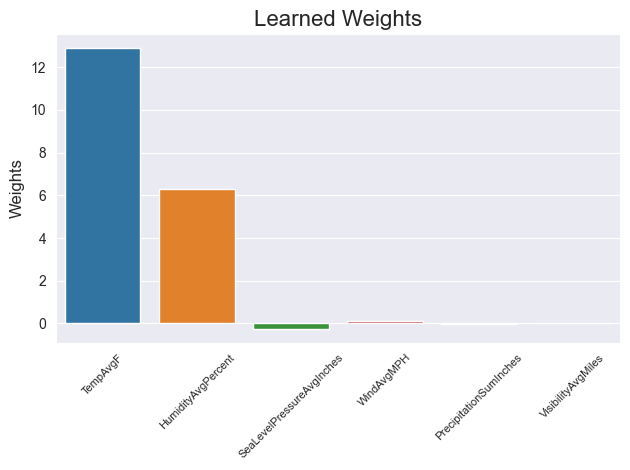

In [43]:
# Look at the weights for each variable
splot = sns.barplot(x=variables, y=weights)
for item in splot.get_xticklabels():
    item.set_rotation(45)
    item.set_size(8)
plt.ylabel("Weights", size=12)
plt.title("Learned Weights", size=16)
plt.tight_layout()

# Logistic Regression Classifiers
## In this example, we will train a logistic regression model to predict whether or not it is raining based on temperature, humidity, sea level pressure, visibility, wind speed, dewpoint, and precipitation.

In [44]:
# Define the sigmoid/logistic function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Define the loss function (log-loss)
def log_loss(p, y):
    cost = 0
    m = len(y)
    for i in range(m):
        cost_a = y[i] * np.log(p[i])
        cost_b = (1 - y[i]) * np.log(1 - p[i])
        cost += cost_a + cost_b
    return -1.0 / m * cost


# Derivative of the loss with respect to weights and bias
def dl_dw_db(x, p, y_actual):
    m = len(y_actual)
    dl_dw = 0.0
    dl_db = 0.0
    for i in range(m):
        dl_dw += np.dot(x[i], (p[i] - y_actual[i]))  # derivative of log-loss with respect to weights
        dl_db += np.sum(p[i] - y_actual[i])  # derivative of log-loss with respect to bias
    return 1 / m * dl_dw, 1 / m * dl_db

In [45]:
# define the training function, which will return the trained weight vector and training history
def train(x_data, y_data, learning_rate: float=0.005, num_epochs: int=10000, bias: float = 0.0):
    weights = np.ones(shape=x_data.shape[1], dtype=float)
    training_loss = []
    # run for user-defined number of epochs
    for _ in tqdm(range(num_epochs)):
        # Perform prediction
        predicted_probability = sigmoid(linear_regressor(weights, bias, x_data))
        # Calculate the loss
        loss_i = log_loss(predicted_probability, y_data)
        # Calculate the gradients
        dl_dw, dl_db = dl_dw_db(x_data, predicted_probability, y_data)
        # Calculate the new weights and biases through gradient descent
        weights -= learning_rate * dl_dw
        bias -= learning_rate * dl_db
        # Store the training loss at this epoch so that we can plot it later
        training_loss.append(loss_i)
    return weights, bias, training_loss

In [46]:
def classify(p, thr=0.5):
    return 1 if p >= thr else 0

In [47]:
def rained(rain_sum):
    r = np.zeros(dtype=int, shape=rain_sum.shape)
    r[rain_sum > 0] = 1
    return r
# Make a new column for the data for rain or no rain
df["Rained"] = rained(df["PrecipitationSumInches"])

In [48]:
# Separate out the variables and classification target
variables = ['TempAvgF', 'HumidityAvgPercent', 'SeaLevelPressureAvgInches', 'WindAvgMPH', 'VisibilityAvgMiles', 'DewPointAvgF']
target = ['Rained']

x_variables = df[variables].to_numpy()
y_targets = df[target].to_numpy().flatten()

# Standardize data
def standardize(data):
    for i in range(data.shape[1]):
        data[:,i] = (data[:,i] - np.mean(data[:,i])) / np.std(data[:,i])
standardize(x_variables)

# Perform train/test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_variables, y_targets, test_size=0.30, random_state=42)

# Train the regressor
weights, bias, training_loss = train(x_train, y_train)

  0%|          | 0/10000 [00:00<?, ?it/s]

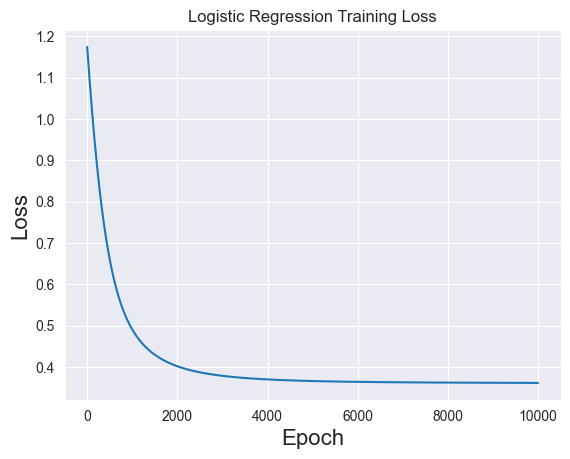

In [49]:
# Plot the training loss
plt.plot(training_loss)
plt.xlabel("Epoch", size=16)
plt.ylabel("Loss", size=16)
plt.title("Logistic Regression Training Loss")
# plt.ylim((0, 200))
plt.show()

In [50]:
# Perform prediction on the testing data
test_probabilities = sigmoid(linear_regressor(weights, bias, x_test))
test_predictions = np.array([classify(p, thr=0.5) for p in test_probabilities])
classify_results_df = pd.DataFrame({"prediction_probabilities": test_probabilities, "predictions": test_predictions, "actual": y_test})

In [51]:
classify_results_df.head(25)

,prediction_probabilities,predictions,actual
0,0.948136,1,1
1,0.689867,1,0
2,0.012966,0,0
3,0.105926,0,0
4,0.147522,0,0
5,0.048326,0,0
6,0.007971,0,0
7,0.057502,0,0
8,0.063198,0,0
9,0.135591,0,0


Text(0.5, 1.0, 'ROC Curve: AUC=0.88')

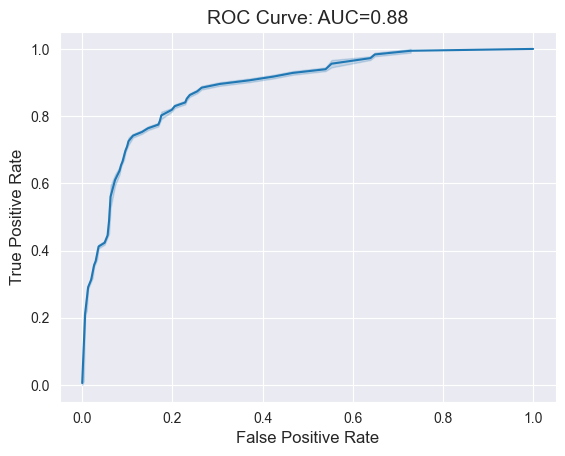

In [52]:
# Create a ROC curve to see relationship between true and false positive rates
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(classify_results_df["actual"], classify_results_df["prediction_probabilities"])
auc = roc_auc_score(y_true=classify_results_df["actual"], y_score=classify_results_df["prediction_probabilities"])
sns.lineplot(x=fpr, y=tpr)
plt.xlabel("False Positive Rate", size=12)
plt.ylabel("True Positive Rate", size=12)
plt.title("ROC Curve: AUC=%.2f" % auc, size=14)

[Text(0, 0.5, 'Clear'), Text(0, 1.5, 'Rained')]

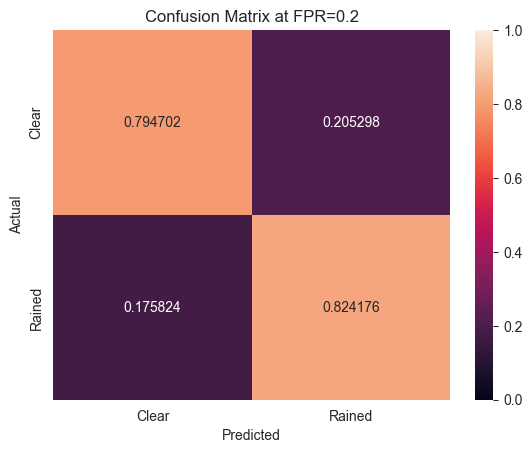

In [53]:
# Let's pick a threshold at FPR=0.2, which is about where the TPR begins to flatten
target_fpr = 0.2
thr = thresholds[np.where(fpr >= target_fpr)[0][0]]
# Get predictions at this threshold
test_predictions_at_thr = (test_probabilities >= thr).astype(int)
# Now let's look at a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, test_predictions_at_thr, normalize='true')
ax = plt.subplot()
sns.heatmap(cm, ax=ax, annot=True, fmt='g', vmin=0.0, vmax=1.0)

plt.title('Confusion Matrix at FPR={0}'.format(target_fpr))
plt.xlabel('Predicted')
plt.ylabel('Actual')

ax.xaxis.set_ticklabels(['Clear', 'Rained'])
ax.yaxis.set_ticklabels(['Clear', 'Rained'])

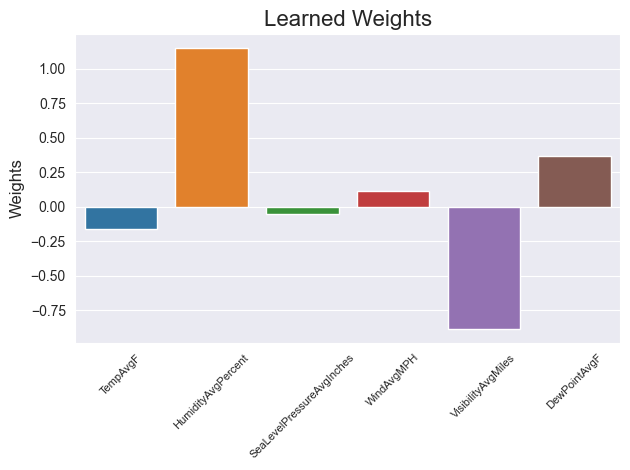

In [54]:
# Look at the weights for each variable
splot = sns.barplot(x=variables, y=weights)
for item in splot.get_xticklabels():
    item.set_rotation(45)
    item.set_size(8)
plt.ylabel("Weights", size=12)
plt.title("Learned Weights", size=16)
plt.tight_layout()